In [1]:
import os

from utils.data_func import *
from utils.auxiliary_func import *
from utils.plots_func import *
import config.const as const
import config.params as params

from scipy.stats import ttest_ind, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

## Define Parameters

In [2]:
DATA_PREPARATION_DIR = const.DATA_PREPARATION_DIR

figure_4_dir = os.path.join(const.BASE_DIR, 'figure_results', 'Figure 4')
os.makedirs(figure_4_dir, exist_ok=True)

### Read files

In [3]:
df_category_with_rcb, all_leap_list, df_category_all = extract_core_resection_from_tnbc(const.RCB_FILE, slide_num = True)
df_category_with_rcb.head()

Core Responder Count: 30
Core Non-Responder Count: 23
Resection Count: 17


,leap_ID,slide_num,sample_type,category,RCB_group
0,015,7,core,non responder,3.0
1,016,7,resection,non responder,3.0
2,017,8,core,non responder,2.0
3,018,8,resection,non responder,2.0
4,019,9,core,non responder,2.0


In [6]:
# Group by 'slide_num' and filter pairs where 'sample_type' contains both 'core' and 'resection'
grouped = df_category_with_rcb.groupby('slide_num')
filtered_groups = grouped.filter(lambda group: set(group['sample_type'].unique()) >= {'core', 'resection'})


## Create the core-resection matched pair similarity rank - Median

### Create median lifetime data frame from all the sample types

In [41]:
sample_type = 'resection'
resection_dir = os.path.join(const.FULL_TISSUE_DIR, sample_type)

resection_median_path = f'{resection_dir}/features_median_data.csv'
resection_median_df = pd.read_csv(resection_median_path,  dtype={'leap_ID': str})
resection_median_df.head()

,leap_ID,lifetime_mean,area,extent,solidity,perimeter,diameter_area,convex_hull_area,minor_axis_length,perimeter_crofton,major_axis_length,orientation,diameter_max,eccentricity,density_radius_20,density_radius_40,density_radius_60,density_radius_80,category
0,016,3.975238,17.0,0.76,0.954545,13.071068,4.652426,18.0,3.993285,15.073666,5.602338,0.000000,5.830952,0.683130,0.011141,0.009748,0.008930,0.008356,non responder
1,018,4.234513,16.0,0.75,0.947368,12.828427,4.513517,18.0,3.679465,15.073666,5.782733,0.000000,6.000000,0.739975,0.007958,0.006764,0.006101,0.005769,non responder
2,020,4.227540,29.0,0.75,0.947368,17.899495,6.076508,31.0,5.212951,19.976625,7.276737,0.000000,7.615773,0.673317,0.011937,0.012136,0.012113,0.012086,non responder
3,029,2.878154,14.0,0.75,0.952381,11.656854,4.222008,15.0,3.289022,13.732908,5.326819,0.000000,5.385165,0.752023,0.007958,0.007560,0.007250,0.007063,non responder
4,033,3.444826,19.0,0.75,0.947368,14.242641,4.918491,21.0,3.938749,16.414425,6.286994,0.050623,6.324555,0.744550,0.010345,0.009748,0.009372,0.009052,non responder


In [42]:
sample_type = 'core'
core_dir = os.path.join(const.FULL_TISSUE_DIR, sample_type)

core_median_path = f'{core_dir}/features_median_data.csv'
core_median_df = pd.read_csv(core_median_path,  dtype={'leap_ID': str})
core_median_df.head()


,leap_ID,lifetime_mean,area,extent,solidity,perimeter,diameter_area,convex_hull_area,minor_axis_length,perimeter_crofton,major_axis_length,orientation,diameter_max,eccentricity,density_radius_20,density_radius_40,density_radius_60,density_radius_80,category
0,015,3.915147,16.0,0.750000,0.954545,12.242641,4.513517,17.0,3.669612,14.518306,5.449354,0.000000,5.385165,0.713180,0.007958,0.005769,0.005040,0.004526,non responder
1,017,4.177300,18.0,0.750000,0.944444,13.656854,4.787307,20.0,3.991464,16.184387,6.065440,0.084918,6.324555,0.722862,0.019099,0.018104,0.016977,0.016015,non responder
2,019,4.465636,17.0,0.755102,0.958333,13.071068,4.652426,18.0,3.894303,15.073666,5.602338,0.000000,5.830952,0.694588,0.016711,0.016910,0.016800,0.016662,non responder
3,021,4.353615,14.0,0.750000,0.960000,11.071068,4.222008,14.0,3.337716,13.732908,5.149449,0.000000,5.385165,0.729661,0.012732,0.011738,0.011406,0.011091,responder
4,023,3.970538,11.0,0.750000,1.000000,9.414214,3.742410,11.0,2.970079,11.836789,4.418072,0.000000,4.472136,0.720941,0.015915,0.014125,0.013528,0.013081,responder


In [43]:
core_responder = core_median_df[core_median_df['category'] == 'responder'][['leap_ID', 'lifetime_mean']]
core_non_responder = core_median_df[core_median_df['category'] == 'non responder'][['leap_ID', 'lifetime_mean']]
resection = resection_median_df[resection_median_df['category']=='non responder'][['leap_ID', 'lifetime_mean']]
# resection = resection_median_df[['leap_ID', 'lifetime_mean']]  # No category filtering needed


In [44]:
# Create labeled DataFrames for each group, using leap_ID and lifetime_mean
df_responder = core_responder.copy()
df_responder['sample_type'] = 'core_responder'

df_non_responder = core_non_responder.copy()
df_non_responder['sample_type'] = 'core_non_responder'

df_resection = resection.copy()
df_resection['sample_type'] = 'resection'

# Combine into a single DataFrame
median_df_all_samples = pd.concat(
    [df_responder, df_non_responder, df_resection],
    ignore_index=True
)[['leap_ID', 'sample_type', 'lifetime_mean']]  # Optional: reorder columns

# Optionally rename column
median_df_all_samples = median_df_all_samples.rename(columns={'lifetime_mean': 'median_lifetime'})



In [45]:
median_df_all_samples.head()

,leap_ID,sample_type,median_lifetime
0,021,core_responder,4.353615
1,023,core_responder,3.970538
2,036,core_responder,4.053200
3,038,core_responder,2.602444
4,041,core_responder,2.059636


In [46]:
output_all_median_path = os.path.join(DATA_PREPARATION_DIR, 'median_lifetime_df_core_and_resection_samples.csv')
median_df_all_samples.to_csv(output_all_median_path, index=False)

### Matched pair similarity rank

In [47]:
filtered_leap_ids = median_df_all_samples['leap_ID'].unique()  
filtered_groups = filtered_groups[filtered_groups['leap_ID'].isin(filtered_leap_ids)]

# Merge Median Lifetime from median_df_all_samples into filtered_groups
filtered_groups_with_median = filtered_groups.merge(
    median_df_all_samples[['leap_ID', 'median_lifetime']],  # columns to merge from
    on='leap_ID',
    how='left' 
)

# Preview the result
filtered_groups_with_median.head()


,leap_ID,slide_num,sample_type,category,RCB_group,median_lifetime
0,015,7,core,non responder,3.0,3.915147
1,016,7,resection,non responder,3.0,3.975238
2,017,8,core,non responder,2.0,4.177300
3,018,8,resection,non responder,2.0,4.234513
4,019,9,core,non responder,3.0,4.465636


In [48]:
pair_dict = {}
# Iterate over groups of 'slide_num' in filtered_groups
for slide_num, group in filtered_groups_with_median.groupby('slide_num'):
    # Filter for 'core' and 'resection' sample types
    core_group = group[group['sample_type'].str.contains("core")]
    resection_group = group[group['sample_type'] == "resection"]
    
    # Only proceed if both 'core' and 'resection' samples exist
    if not core_group.empty and not resection_group.empty:
        # Get leap_IDs and median lifetime values
        core_leap_id, core_lifetime = core_group['leap_ID'].values[0], core_group['median_lifetime'].values[0]
        resection_leap_id, resection_lifetime = resection_group['leap_ID'].values[0],  resection_group['median_lifetime'].values[0]

        # Calculate absolute difference
        diff_couple = abs(core_lifetime - resection_lifetime)
        print(f"core: {core_leap_id}, resection: {resection_leap_id}, difference: {diff_couple}")

        other_core_nr = []
        for _,row in median_df_all_samples.iterrows():
            if row['sample_type'] == 'core_non_responder' and row['leap_ID'] != core_leap_id: 
                diff_pair_nr = abs(row['median_lifetime'] - resection_lifetime)
                other_core_nr.append(diff_pair_nr)            
        
        other_core_r = []
        for _,row in median_df_all_samples.iterrows():
            if row['sample_type'] == 'core_responder' and row['leap_ID'] != core_leap_id: 
                diff_pair_r = abs(row['median_lifetime'] - resection_lifetime)
                other_core_r.append(diff_pair_r) 
        
        pair_dict[(core_leap_id, resection_leap_id)] = {'couple_diff': diff_couple, 'other_core_nr_diff': other_core_nr, 'other_core_r_diff':other_core_r}    

core: 015, resection: 016, difference: 0.06009103641456637
core: 017, resection: 018, difference: 0.05721282051282017
core: 019, resection: 020, difference: 0.23809636363636333
core: 028, resection: 029, difference: 0.9069538461538462
core: 032, resection: 033, difference: 0.9290448369565212
core: 034, resection: 035, difference: 0.1350630252100844
core: 039, resection: 040, difference: 0.028833333333333933
core: 046, resection: 047, difference: 0.6533571428571427
core: 048, resection: 049, difference: 0.24651044932079325
core: 050, resection: 051, difference: 0.0836607142857142
core: 064, resection: 065, difference: 0.058428322152856094
core: 073, resection: 074, difference: 0.16764674922600653
core: 093, resection: 094, difference: 0.013509677419354826
core: 106, resection: 107, difference: 0.06623976608187165


In [49]:
rank_data = []

for (core_id, resection_id), values in pair_dict.items():
    couple_diff = values['couple_diff']
    other_core_nr_diff = values['other_core_nr_diff']
    other_core_r_diff = values['other_core_r_diff']

    # Combine couple_diff with other_core_nr_diff and rank
    nr_diff_with_couple = other_core_nr_diff + [couple_diff]
    nr_diff_sorted = sorted(nr_diff_with_couple)
    nr_rank = nr_diff_sorted.index(couple_diff) + 1  # Get rank (1-based)

    # Save for DataFrame
    rank_data.append({
        'core_leap_id': core_id,
        'resection_leap_id': resection_id,
        'nr_rank': nr_rank,
    })

# Create DataFrame and save as CSV
median_rank_df = pd.DataFrame(rank_data)
median_rank_df.head()


,core_leap_id,resection_leap_id,nr_rank
0,015,016,1
1,017,018,3
2,019,020,4
3,028,029,17
4,032,033,18


In [50]:
median_core_resection_ranking_path = os.path.join(DATA_PREPARATION_DIR, 'core_resection_median_matched_pair_ranking.csv' )
median_rank_df.to_csv(median_core_resection_ranking_path, index=False)

print(f"CSV saved to {median_core_resection_ranking_path}")

CSV saved to /sise/assafzar-group/assafzar/reut/Test_FLIM/from_FLIM_dir/figure_results/data_preparation/core_resection_median_matched_pair_ranking.csv


## Create the core-resection matched pair similarity rank - Distribution

### Create lifetime distribution data frame from all the sample types

In [86]:
sample_type = 'resection'
distri_file_name = 'features_lifetime_distribution_data_max_val_13_bins_amount_18_bin_range_0.73.csv'
resection_dir = os.path.join(const.FULL_TISSUE_DIR, sample_type)

resection_distri_path = f'{resection_dir}/{distri_file_name}'
resection_distri_df = pd.read_csv(resection_distri_path,  dtype={'leap_ID': str})
resection_distri_df.head()

,lifetime_mean_0.0-0.73,lifetime_mean_0.73-1.46,lifetime_mean_1.46-2.19,lifetime_mean_2.19-2.92,lifetime_mean_2.92-3.65,lifetime_mean_3.65-4.38,lifetime_mean_4.38-5.109999999999999,lifetime_mean_5.109999999999999-5.84,lifetime_mean_5.84-6.57,lifetime_mean_6.57-7.3,lifetime_mean_7.3-8.03,lifetime_mean_8.03-8.76,lifetime_mean_8.76-9.49,lifetime_mean_9.49-10.219999999999999,lifetime_mean_10.219999999999999-10.95,lifetime_mean_10.95-11.68,lifetime_mean_11.68-12.41,lifetime_mean_12.41-13.14,leap_ID,categories
0,0.022280,0.000245,0.000257,0.003904,0.044396,0.897029,0.031465,0.000307,0.000070,0.000016,0.000008,0.000012,0.000004,0.000004,0.000000,0.0,0.0,0.000004,016,0
1,0.000000,0.000237,0.000087,0.002800,0.035398,0.691132,0.270229,0.000107,0.000004,0.000002,0.000000,0.000002,0.000000,0.000000,0.000002,0.0,0.0,0.000000,018,0
2,0.000000,0.000011,0.000026,0.001436,0.009227,0.775084,0.214214,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,020,0
3,0.011815,0.022588,0.063094,0.479492,0.423009,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,029,0
4,0.023908,0.007184,0.017663,0.109280,0.598915,0.243051,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,033,0


In [87]:
sample_type = 'core'
distri_file_name = 'features_lifetime_distribution_data_max_val_13_bins_amount_18_bin_range_0.73.csv'
core_dir = os.path.join(const.FULL_TISSUE_DIR, sample_type)

core_distri_path = f'{core_dir}/{distri_file_name}'
core_distri_df = pd.read_csv(core_distri_path,  dtype={'leap_ID': str})
core_distri_df.head()

,lifetime_mean_0.0-0.73,lifetime_mean_0.73-1.46,lifetime_mean_1.46-2.19,lifetime_mean_2.19-2.92,lifetime_mean_2.92-3.65,lifetime_mean_3.65-4.38,lifetime_mean_4.38-5.109999999999999,lifetime_mean_5.109999999999999-5.84,lifetime_mean_5.84-6.57,lifetime_mean_6.57-7.3,lifetime_mean_7.3-8.03,lifetime_mean_8.03-8.76,lifetime_mean_8.76-9.49,lifetime_mean_9.49-10.219999999999999,lifetime_mean_10.219999999999999-10.95,lifetime_mean_10.95-11.68,lifetime_mean_11.68-12.41,lifetime_mean_12.41-13.14,leap_ID,categories
0,0.0,0.000370,0.006297,0.018450,0.145427,0.820404,0.008890,0.000093,0.000046,0.000023,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,015,0
1,0.0,0.000029,0.000048,0.000092,0.013817,0.883741,0.102244,0.000024,0.000000,0.000000,0.000005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,017,0
2,0.0,0.000000,0.000000,0.000066,0.000976,0.352698,0.646233,0.000027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,019,0
3,0.0,0.000000,0.000063,0.000042,0.001890,0.553116,0.444477,0.000384,0.000007,0.000007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000014,0.000000,0.000000,021,1
4,0.0,0.001145,0.001335,0.007055,0.156732,0.762043,0.068250,0.002747,0.000433,0.000131,0.000065,0.000024,0.000012,0.000006,0.000006,0.000000,0.000012,0.000006,023,1


In [88]:
distri_cols = [c for c in resection_distri_df.columns if "lifetime_mean" in c]
cols_to_keep = distri_cols + ["leap_ID"]

In [89]:
core_responder = core_distri_df[core_distri_df['categories'] == 1][cols_to_keep]
core_non_responder = core_distri_df[core_distri_df['categories'] == 0][cols_to_keep]
resection = resection_distri_df[resection_distri_df['categories']==0][cols_to_keep]

In [90]:
# Create labeled DataFrames for each group, using leap_ID and lifetime_mean
df_responder = core_responder.copy()
df_responder['sample_type'] = 'core_responder'

df_non_responder = core_non_responder.copy()
df_non_responder['sample_type'] = 'core_non_responder'

df_resection = resection.copy()
df_resection['sample_type'] = 'resection'

# Combine into a single DataFrame
distri_df_all_samples = pd.concat(
    [df_responder, df_non_responder, df_resection],
    ignore_index=True
)

In [91]:
output_all_distri_path = os.path.join(DATA_PREPARATION_DIR, 'distribution_lifetime_df_core_and_resection_samples.csv')
distri_df_all_samples.to_csv(output_all_distri_path, index=False)

In [108]:
distri_df_all_samples.head()

,lifetime_mean_0.0-0.73,lifetime_mean_0.73-1.46,lifetime_mean_1.46-2.19,lifetime_mean_2.19-2.92,lifetime_mean_2.92-3.65,lifetime_mean_3.65-4.38,lifetime_mean_4.38-5.109999999999999,lifetime_mean_5.109999999999999-5.84,lifetime_mean_5.84-6.57,lifetime_mean_6.57-7.3,lifetime_mean_7.3-8.03,lifetime_mean_8.03-8.76,lifetime_mean_8.76-9.49,lifetime_mean_9.49-10.219999999999999,lifetime_mean_10.219999999999999-10.95,lifetime_mean_10.95-11.68,lifetime_mean_11.68-12.41,lifetime_mean_12.41-13.14,leap_ID,sample_type
0,0.000000,0.000000,0.000063,0.000042,0.001890,0.553116,0.444477,0.000384,0.000007,0.000007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000014,0.000000,0.000000,021,core_responder
1,0.000000,0.001145,0.001335,0.007055,0.156732,0.762043,0.068250,0.002747,0.000433,0.000131,0.000065,0.000024,0.000012,0.000006,0.000006,0.000000,0.000012,0.000006,023,core_responder
2,0.000000,0.000107,0.000221,0.005798,0.074414,0.728875,0.163204,0.019139,0.004503,0.001577,0.000815,0.000373,0.000290,0.000198,0.000206,0.000107,0.000107,0.000069,036,core_responder
3,0.000325,0.003373,0.062049,0.877166,0.057087,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,038,core_responder
4,0.022962,0.157536,0.410912,0.406276,0.002313,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,041,core_responder


### Matched pair similarity rank

In [130]:
filtered_leap_ids = distri_df_all_samples['leap_ID'].unique()  
filtered_groups = filtered_groups[filtered_groups['leap_ID'].isin(filtered_leap_ids)]

# Merge Median Lifetime from median_df_all_samples into filtered_groups
filtered_groups_with_distri = filtered_groups.merge(
   distri_df_all_samples[cols_to_keep],  # columns to merge from
    on='leap_ID',
    how='left' 
)

# Preview the result
filtered_groups_with_distri.head()

,leap_ID,slide_num,sample_type,category,RCB_group,lifetime_mean_0.0-0.73,lifetime_mean_0.73-1.46,lifetime_mean_1.46-2.19,lifetime_mean_2.19-2.92,lifetime_mean_2.92-3.65,...,lifetime_mean_5.84-6.57,lifetime_mean_6.57-7.3,lifetime_mean_7.3-8.03,lifetime_mean_8.03-8.76,lifetime_mean_8.76-9.49,lifetime_mean_9.49-10.219999999999999,lifetime_mean_10.219999999999999-10.95,lifetime_mean_10.95-11.68,lifetime_mean_11.68-12.41,lifetime_mean_12.41-13.14
0,015,7,core,non responder,3.0,0.00000,0.000370,0.006297,0.018450,0.145427,...,0.000046,0.000023,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
1,016,7,resection,non responder,3.0,0.02228,0.000245,0.000257,0.003904,0.044396,...,0.000070,0.000016,0.000008,0.000012,0.000004,0.000004,0.000000,0.0,0.0,0.000004
2,017,8,core,non responder,2.0,0.00000,0.000029,0.000048,0.000092,0.013817,...,0.000000,0.000000,0.000005,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
3,018,8,resection,non responder,2.0,0.00000,0.000237,0.000087,0.002800,0.035398,...,0.000004,0.000002,0.000000,0.000002,0.000000,0.000000,0.000002,0.0,0.0,0.000000
4,019,9,core,non responder,3.0,0.00000,0.000000,0.000000,0.000066,0.000976,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000


#### Euclidean

In [146]:
from scipy.spatial.distance import euclidean

import numpy as np

distri_pair_dict = {}
# Iterate over groups of 'slide_num' in filtered_groups
for slide_num, group in filtered_groups_with_distri.groupby('slide_num'):
    # Filter for 'core' and 'resection' sample types
    core_group = group[group['sample_type'].str.contains("core")]
    resection_group = group[group['sample_type'] == "resection"]
    
    # Only proceed if both 'core' and 'resection' samples exist
    if not core_group.empty and not resection_group.empty:
        core_leap_id = core_group['leap_ID'].values[0]
        resection_leap_id = resection_group['leap_ID'].values[0]

        core_vector = core_group[distri_cols].values[0]
        resection_vector = resection_group[distri_cols].values[0]

        diff_couple = euclidean(core_vector, resection_vector)
        print(f"core: {core_leap_id}, resection: {resection_leap_id}, difference: {diff_couple:.4f}")


        other_core_nr = []
        for _,row in distri_df_all_samples.iterrows():
            if row['sample_type'] == 'core_non_responder' and row['leap_ID'] != core_leap_id: 
                other_leap_id = row['leap_ID']
                other_core_vector = row[distri_cols].values.tolist()
                diff_pair_nr =  euclidean(other_core_vector, resection_vector)
                other_core_nr.append((diff_pair_nr, other_leap_id))          
        
        other_core_r = []
        for _,row in distri_df_all_samples.iterrows():
            if row['sample_type'] == 'core_responder' and row['leap_ID'] != core_leap_id: 
                other_leap_id = row['leap_ID']
                other_core_vector = row[distri_cols].values.tolist()
                diff_pair_r =  euclidean(other_core_vector, resection_vector)
                other_core_r.append((diff_pair_r, other_leap_id))          
        
        distri_pair_dict[(core_leap_id, resection_leap_id)] = {'couple_diff': diff_couple, 'other_core_nr_diff': other_core_nr, 'other_core_r_diff':other_core_r}    

core: 015, resection: 016, difference: 0.1317
core: 017, resection: 018, difference: 0.2565
core: 019, resection: 020, difference: 0.6043
core: 028, resection: 029, difference: 0.4820
core: 032, resection: 033, difference: 0.5539
core: 034, resection: 035, difference: 0.2970
core: 039, resection: 040, difference: 0.2432
core: 046, resection: 047, difference: 0.5851
core: 048, resection: 049, difference: 0.1394
core: 050, resection: 051, difference: 0.3985
core: 064, resection: 065, difference: 0.2029
core: 073, resection: 074, difference: 0.1754
core: 093, resection: 094, difference: 0.0175
core: 106, resection: 107, difference: 0.3559


In [147]:
rank_data = []

for (core_id, resection_id), values in distri_pair_dict.items():
    couple_diff = values['couple_diff']
    other_core_nr_diff = [item[0] for item in values['other_core_nr_diff']] 
    other_core_r_diff = [item[0] for item in values['other_core_r_diff']]

    # Combine couple_diff with other_core_nr_diff and rank
    nr_diff_with_couple = other_core_nr_diff + [couple_diff]
    nr_diff_sorted = sorted(nr_diff_with_couple)
    nr_rank = nr_diff_sorted.index(couple_diff) + 1  # Get rank (1-based)

    # Save for DataFrame
    rank_data.append({
        'core_leap_id': core_id,
        'resection_leap_id': resection_id,
        'nr_rank': nr_rank,
    })

# Create DataFrame and save as CSV
distri_rank_df = pd.DataFrame(rank_data)
distri_rank_df.head()


,core_leap_id,resection_leap_id,nr_rank
0,015,016,2
1,017,018,3
2,019,020,5
3,028,029,5
4,032,033,10


In [148]:
distri_core_resection_ranking_path = os.path.join(DATA_PREPARATION_DIR, 'core_resection_euclidean_distribution_matched_pair_ranking.csv' )
distri_rank_df.to_csv(distri_core_resection_ranking_path, index=False)

print(f"CSV saved to {distri_core_resection_ranking_path}")

CSV saved to /sise/assafzar-group/assafzar/reut/Test_FLIM/from_FLIM_dir/figure_results/data_preparation/core_resection_euclidean_distribution_matched_pair_ranking.csv


#### Jensen-Shannon divergence Metric

In [149]:
from scipy.spatial.distance import jensenshannon

import numpy as np

distri_pair_dict = {}
# Iterate over groups of 'slide_num' in filtered_groups
for slide_num, group in filtered_groups_with_distri.groupby('slide_num'):
    # Filter for 'core' and 'resection' sample types
    core_group = group[group['sample_type'].str.contains("core")]
    resection_group = group[group['sample_type'] == "resection"]
    
    # Only proceed if both 'core' and 'resection' samples exist
    if not core_group.empty and not resection_group.empty:
        core_leap_id = core_group['leap_ID'].values[0]
        resection_leap_id = resection_group['leap_ID'].values[0]

        core_vector = core_group[distri_cols].values[0]
        resection_vector = resection_group[distri_cols].values[0]

        diff_couple = jensenshannon(core_vector, resection_vector)
        print(f"core: {core_leap_id}, resection: {resection_leap_id}, difference: {diff_couple:.4f}")


        other_core_nr = []
        for _,row in distri_df_all_samples.iterrows():
            if row['sample_type'] == 'core_non_responder' and row['leap_ID'] != core_leap_id: 
                other_leap_id = row['leap_ID']
                other_core_vector = row[distri_cols].values.tolist()
                diff_pair_nr =  jensenshannon(other_core_vector, resection_vector)
                other_core_nr.append((diff_pair_nr, other_leap_id))          
        
        other_core_r = []
        for _,row in distri_df_all_samples.iterrows():
            if row['sample_type'] == 'core_responder' and row['leap_ID'] != core_leap_id: 
                other_leap_id = row['leap_ID']
                other_core_vector = row[distri_cols].values.tolist()
                diff_pair_r =  jensenshannon(other_core_vector, resection_vector)
                other_core_r.append((diff_pair_r, other_leap_id))          
        
        distri_pair_dict[(core_leap_id, resection_leap_id)] = {'couple_diff': diff_couple, 'other_core_nr_diff': other_core_nr, 'other_core_r_diff':other_core_r}    

core: 015, resection: 016, difference: 0.1745
core: 017, resection: 018, difference: 0.1699
core: 019, resection: 020, difference: 0.3156
core: 028, resection: 029, difference: 0.4224
core: 032, resection: 033, difference: 0.4576
core: 034, resection: 035, difference: 0.1693
core: 039, resection: 040, difference: 0.1661
core: 046, resection: 047, difference: 0.4910
core: 048, resection: 049, difference: 0.1667
core: 050, resection: 051, difference: 0.2716
core: 064, resection: 065, difference: 0.1463
core: 073, resection: 074, difference: 0.1857
core: 093, resection: 094, difference: 0.0408
core: 106, resection: 107, difference: 0.2023


In [150]:
rank_data = []

for (core_id, resection_id), values in distri_pair_dict.items():
    couple_diff = values['couple_diff']
    other_core_nr_diff = [item[0] for item in values['other_core_nr_diff']] 
    other_core_r_diff = [item[0] for item in values['other_core_r_diff']]

    # Combine couple_diff with other_core_nr_diff and rank
    nr_diff_with_couple = other_core_nr_diff + [couple_diff]
    nr_diff_sorted = sorted(nr_diff_with_couple)
    nr_rank = nr_diff_sorted.index(couple_diff) + 1  # Get rank (1-based)

    # Save for DataFrame
    rank_data.append({
        'core_leap_id': core_id,
        'resection_leap_id': resection_id,
        'nr_rank': nr_rank,
    })

# Create DataFrame and save as CSV
distri_rank_df = pd.DataFrame(rank_data)
distri_rank_df.head()


,core_leap_id,resection_leap_id,nr_rank
0,015,016,2
1,017,018,3
2,019,020,4
3,028,029,11
4,032,033,11


In [151]:
distri_core_resection_ranking_path = os.path.join(DATA_PREPARATION_DIR, 'core_resection_JS_distribution_matched_pair_ranking.csv' )
distri_rank_df.to_csv(distri_core_resection_ranking_path, index=False)

print(f"CSV saved to {distri_core_resection_ranking_path}")

CSV saved to /sise/assafzar-group/assafzar/reut/Test_FLIM/from_FLIM_dir/figure_results/data_preparation/core_resection_JS_distribution_matched_pair_ranking.csv


#### Earth Mover’s Distance (EMD) Metric

In [152]:
from scipy.stats import wasserstein_distance

distri_pair_dict = {}

# Iterate over groups of 'slide_num' in filtered_groups
for slide_num, group in filtered_groups_with_distri.groupby('slide_num'):
    # Filter for 'core' and 'resection' sample types
    core_group = group[group['sample_type'].str.contains("core")]
    resection_group = group[group['sample_type'] == "resection"]
    
    # Only proceed if both 'core' and 'resection' samples exist
    if not core_group.empty and not resection_group.empty:
        core_leap_id = core_group['leap_ID'].values[0]
        resection_leap_id = resection_group['leap_ID'].values[0]

        core_vector = core_group[distri_cols].values[0]
        resection_vector = resection_group[distri_cols].values[0]

        diff_couple = wasserstein_distance(core_vector, resection_vector)
        print(f"core: {core_leap_id}, resection: {resection_leap_id}, EMD: {diff_couple:.4f}")

        other_core_nr = []
        for _, row in distri_df_all_samples.iterrows():
            if row['sample_type'] == 'core_non_responder' and row['leap_ID'] != core_leap_id:
                other_leap_id = row['leap_ID']
                other_core_vector = row[distri_cols].values
                diff_pair_nr = wasserstein_distance(other_core_vector, resection_vector)
                other_core_nr.append((diff_pair_nr, other_leap_id))

        other_core_r = []
        for _, row in distri_df_all_samples.iterrows():
            if row['sample_type'] == 'core_responder' and row['leap_ID'] != core_leap_id:
                other_leap_id = row['leap_ID']
                other_core_vector = row[distri_cols].values
                diff_pair_r = wasserstein_distance(other_core_vector, resection_vector)
                other_core_r.append((diff_pair_r, other_leap_id))

        distri_pair_dict[(core_leap_id, resection_leap_id)] = {
            'couple_diff': diff_couple,
            'other_core_nr_diff': other_core_nr,
            'other_core_r_diff': other_core_r
        }


core: 015, resection: 016, EMD: 0.0115
core: 017, resection: 018, EMD: 0.0214
core: 019, resection: 020, EMD: 0.0154
core: 028, resection: 029, EMD: 0.0331
core: 032, resection: 033, EMD: 0.0218
core: 034, resection: 035, EMD: 0.0244
core: 039, resection: 040, EMD: 0.0213
core: 046, resection: 047, EMD: 0.0051
core: 048, resection: 049, EMD: 0.0120
core: 050, resection: 051, EMD: 0.0362
core: 064, resection: 065, EMD: 0.0163
core: 073, resection: 074, EMD: 0.0144
core: 093, resection: 094, EMD: 0.0016
core: 106, resection: 107, EMD: 0.0282


In [153]:
rank_data = []

for (core_id, resection_id), values in distri_pair_dict.items():
    couple_diff = values['couple_diff']
    other_core_nr_diff = [item[0] for item in values['other_core_nr_diff']] 
    other_core_r_diff = [item[0] for item in values['other_core_r_diff']]

    # Combine couple_diff with other_core_nr_diff and rank
    nr_diff_with_couple = other_core_nr_diff + [couple_diff]
    nr_diff_sorted = sorted(nr_diff_with_couple)
    nr_rank = nr_diff_sorted.index(couple_diff) + 1  # Get rank (1-based)

    # Save for DataFrame
    rank_data.append({
        'core_leap_id': core_id,
        'resection_leap_id': resection_id,
        'nr_rank': nr_rank,
    })

# Create DataFrame and save as CSV
distri_rank_df = pd.DataFrame(rank_data)
distri_rank_df.head()


,core_leap_id,resection_leap_id,nr_rank
0,015,016,10
1,017,018,14
2,019,020,12
3,028,029,10
4,032,033,10


In [154]:
distri_core_resection_ranking_path = os.path.join(DATA_PREPARATION_DIR, 'core_resection_EMD_distribution_matched_pair_ranking.csv' )
distri_rank_df.to_csv(distri_core_resection_ranking_path, index=False)

print(f"CSV saved to {distri_core_resection_ranking_path}")

CSV saved to /sise/assafzar-group/assafzar/reut/Test_FLIM/from_FLIM_dir/figure_results/data_preparation/core_resection_EMD_distribution_matched_pair_ranking.csv


### Plot distributions

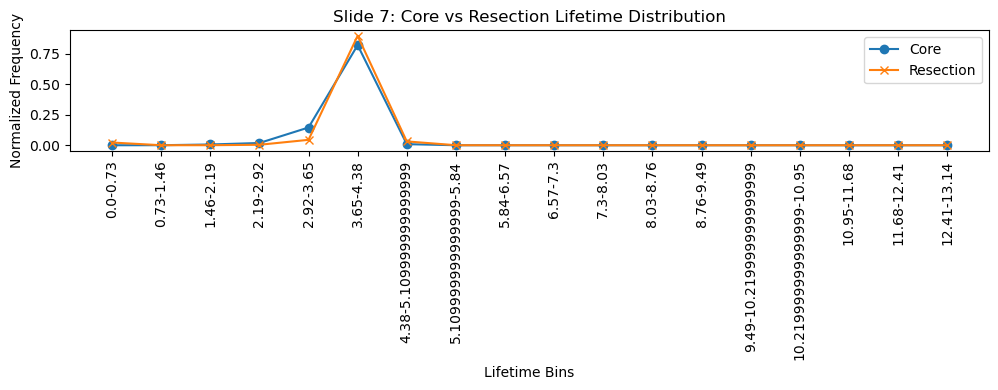

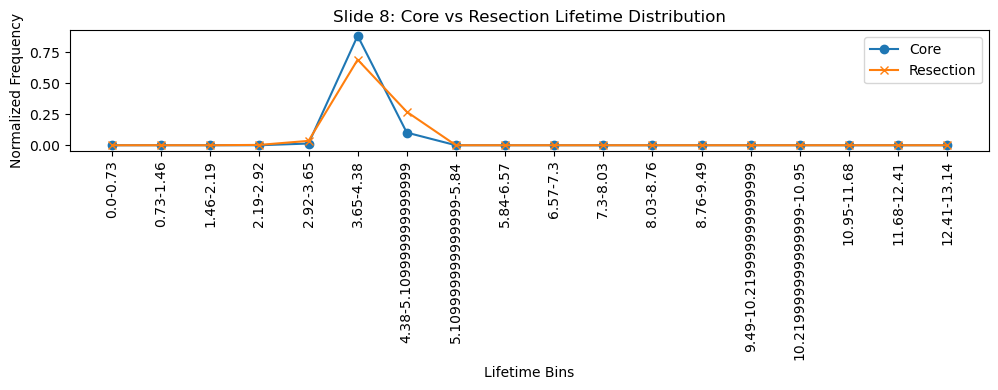

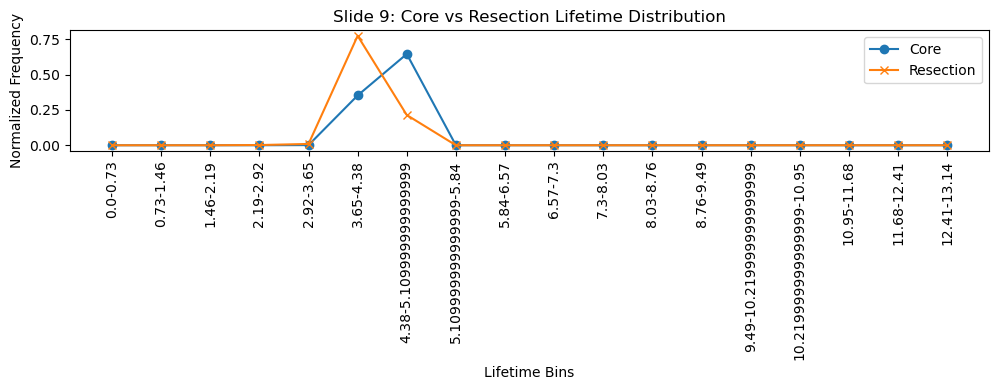

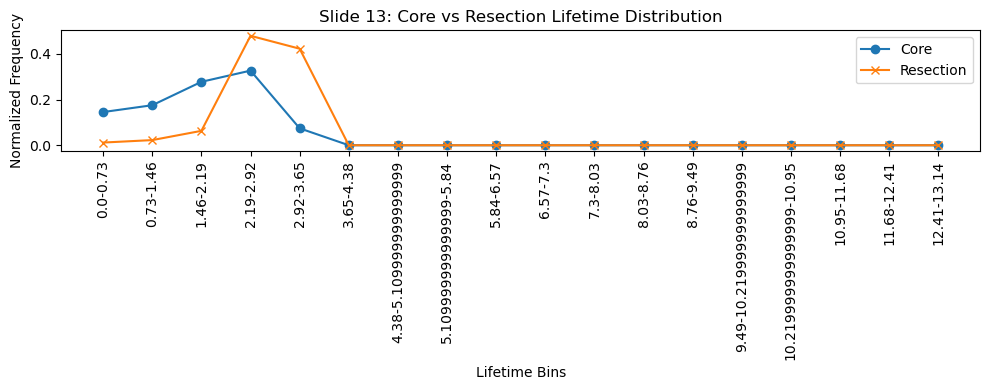

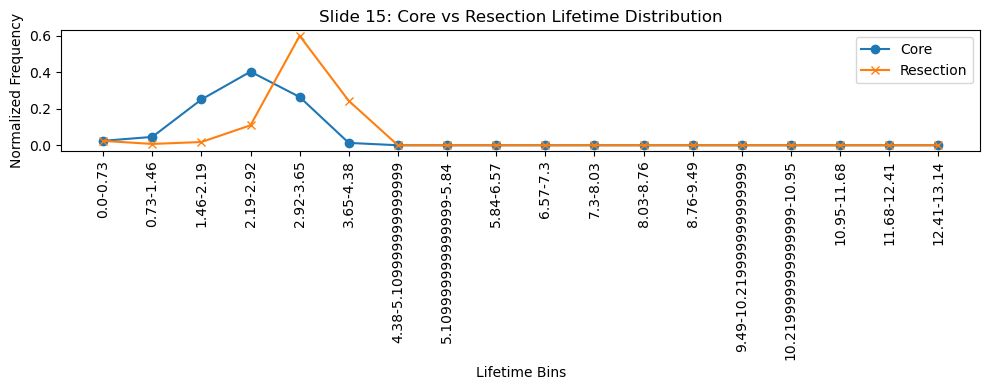

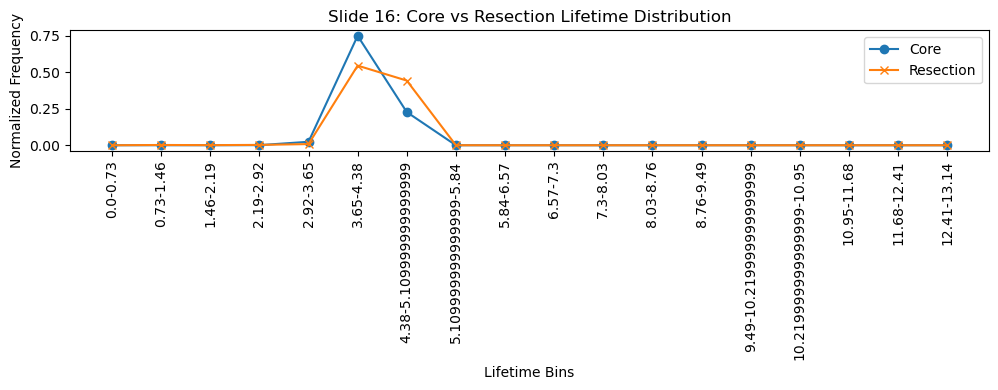

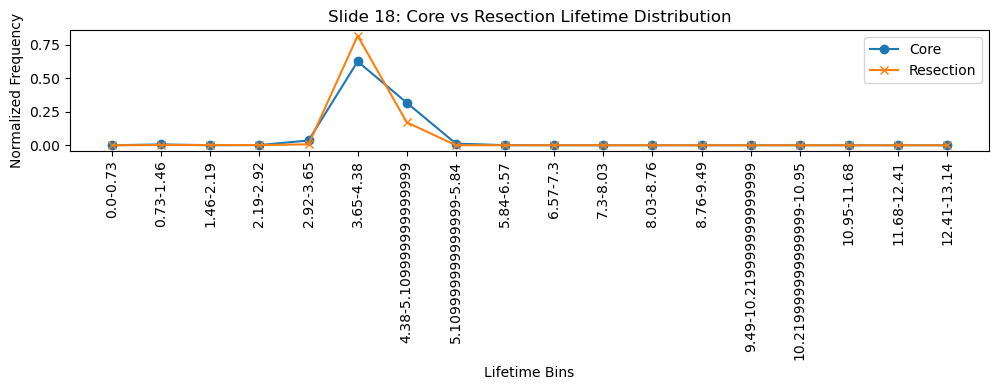

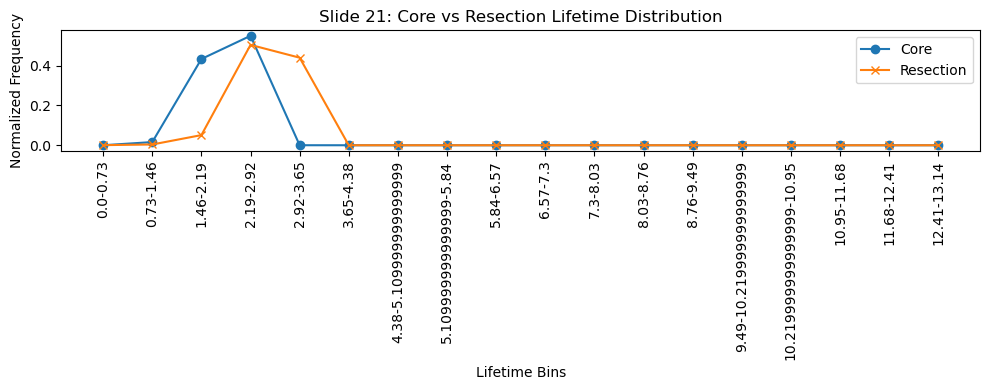

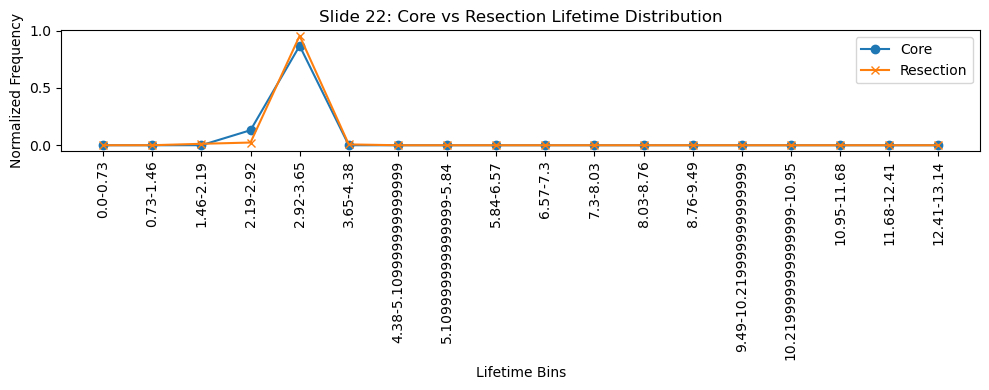

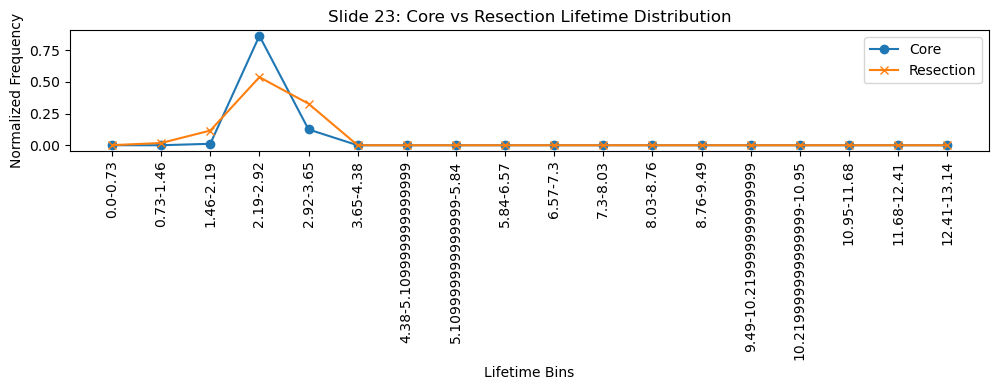

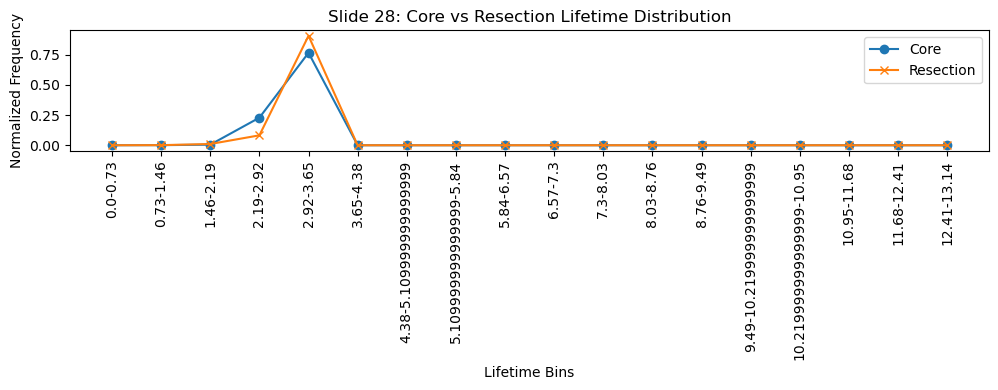

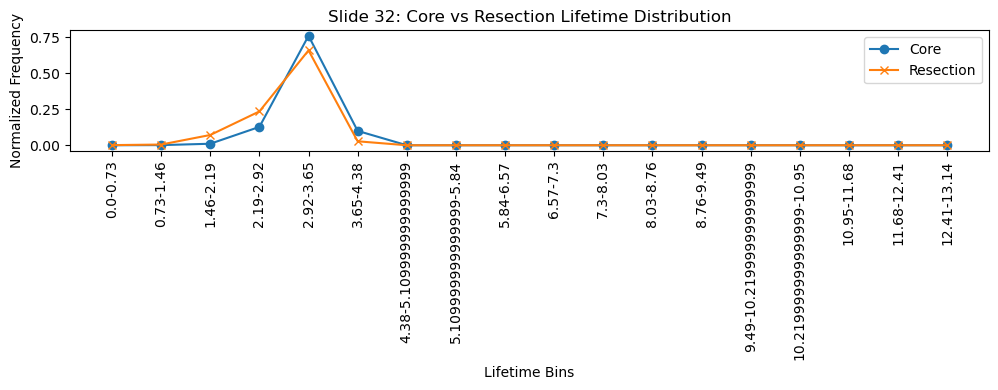

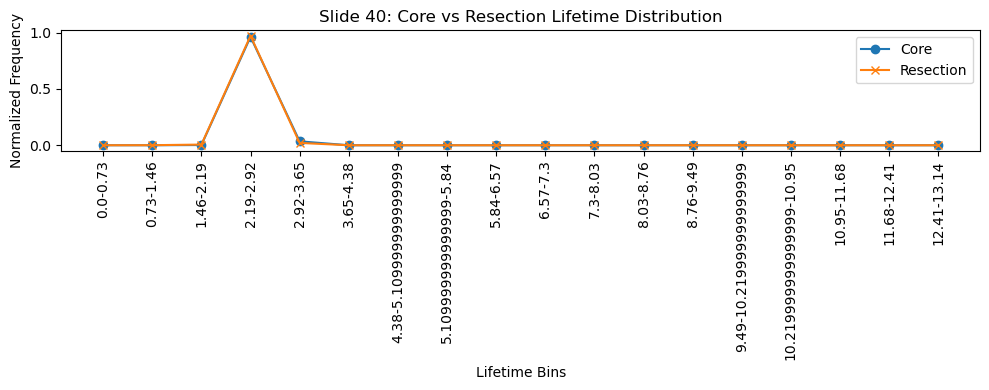

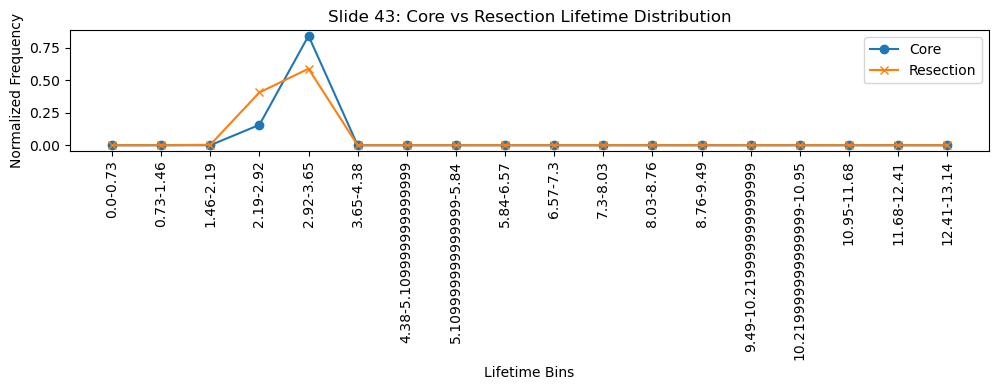

In [129]:
import matplotlib.pyplot as plt

# 1. Get list of distribution columns (bins)
distri_cols = [col for col in filtered_groups_with_distri.columns if col.startswith("lifetime_mean")]

# 2. Group by slide_num
for slide_num, group in filtered_groups_with_distri.groupby('slide_num'):
    # 3. Get core and resection rows
    core_row = group[group['sample_type'].str.contains("core", case=False)]
    resection_row = group[group['sample_type'] == "resection"]

    if core_row.empty or resection_row.empty:
        continue  # Skip if one is missing

    core_vector = core_row[distri_cols].values[0]
    resection_vector = resection_row[distri_cols].values[0]

    # 4. Plot
    plt.figure(figsize=(10, 4))
    x = range(len(distri_cols))  # x-axis = bin index or optionally bin centers
    plt.plot(x, core_vector, label='Core', marker='o')
    plt.plot(x, resection_vector, label='Resection', marker='x')
    
    plt.title(f"Slide {slide_num}: Core vs Resection Lifetime Distribution")
    plt.xlabel("Lifetime Bins")
    plt.ylabel("Normalized Frequency")
    plt.xticks(ticks=x, labels=[col.replace("lifetime_mean_", "") for col in distri_cols], rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [120]:
control_vector = distri_df_all_samples[distri_df_all_samples['leap_ID']=='048'][distri_cols].values[0]

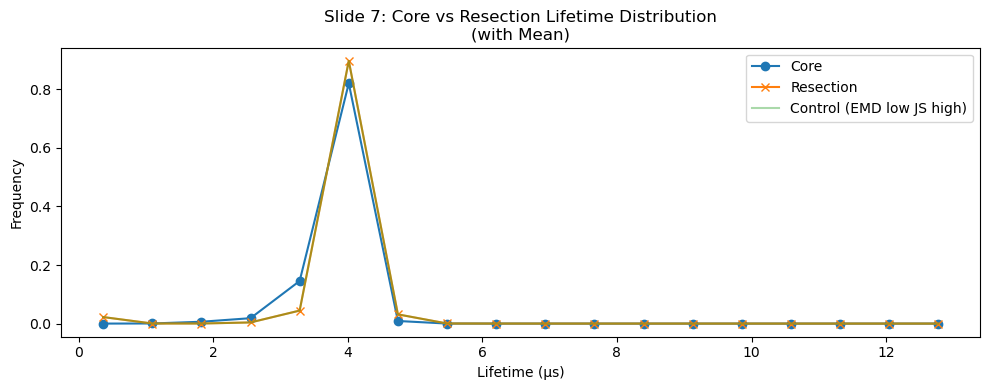

In [155]:
# Simulate bin centers based on lifetime column names
def get_bin_centers(columns):
    return np.array([
        np.mean([float(x) for x in col.replace("lifetime_mean_", "").split('-')])
        for col in columns
    ])

# Group by slide_num
for slide_num, group in filtered_groups_with_distri.groupby('slide_num'):
    core_row = group[group['sample_type'].str.contains("core", case=False)]
    resection_row = group[group['sample_type'] == "resection"]

    if core_row.empty or resection_row.empty:
        continue

    core_vector = core_row[distri_cols].values[0]
    resection_vector = resection_row[distri_cols].values[0]

    bin_centers = get_bin_centers(distri_cols)

    # Calculate weighted means
    core_mean = np.average(bin_centers, weights=core_vector)
    resection_mean = np.average(bin_centers, weights=resection_vector)
    control_mean = np.average(bin_centers, weights=control_vector)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(bin_centers, core_vector, label='Core', marker='o')
    plt.plot(bin_centers, resection_vector, label='Resection', marker='x')
    plt.plot(bin_centers, resection_vector, label='Control (EMD low JS high)', alpha=0.4)


    # # Mean lines
    # plt.axvline(core_mean, color='blue', linestyle='--', label=f'Core Mean: {core_mean:.2f} µs')
    # plt.axvline(resection_mean, color='orange', linestyle='--', label=f'Resection Mean: {resection_mean:.2f} µs')
    # plt.axvline(control_mean, color='green', linestyle='--', label=f'Control Mean: {control_mean:.2f} µs')


    plt.title(f"Slide {slide_num}: Core vs Resection Lifetime Distribution\n(with Mean)")
    plt.xlabel("Lifetime (µs)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    break
